DEEP LEARNING PROJECT

PROBLEM STATEMENT: AI diagnostics in bone oncology for predicting bone metastasis in lung cancer patients

1. S SWARATHMICA - 125156119
2. PARITOSH SRIVASTAVA- 125156083
3. GOPIDI PRANAY - 125156086
4. KARTHIK NARAYAN MOHAN - 125156054 

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# Load EfficientNetB0 with preprocessing
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

In [3]:
# Modify the final output layer to match the number of classes 
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)  # Use 'softmax' for multi-class classification

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model for multi-class classification
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define your dataset directory and target directories for split
dataset_dir = r"E:\Conferences\Lung_Cancer\Lung_Cancer_Data\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset"
train_dir = r"E:\Conferences\Lung_Cancer\Lung_Cancer_Data\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset\Train"
val_dir = r"E:\Conferences\Lung_Cancer\Lung_Cancer_Data\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset\Val"
test_dir = r"E:\Conferences\Lung_Cancer\Lung_Cancer_Data\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset\Test"

# Create directories if they do not exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Minimum samples required for a class to proceed
min_samples = 2

# Iterate over each class folder in the dataset directory
print("Classes in dataset directory:")
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    
    if os.path.isdir(class_path):
        # Get all image files in the class folder, excluding hidden files
        all_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
        all_files = [os.path.join(class_path, file) for file in all_files]

        print(f"Checking class path: {class_path} - Found {len(all_files)} files")

        # Only proceed if there are enough samples
        if len(all_files) >= min_samples:
            if len(all_files) == 2:
                # If there are exactly 2 images, use one for training and one for testing
                train_files = all_files[:1]
                test_files = all_files[1:]
                val_files = []
            else:
                # Split the files into train and remaining (for validation and test)
                train_files, temp_files = train_test_split(all_files, test_size=0.3, random_state=42)  # 70% train, 30% temp
                val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)  # 50% of the remaining for val and test

            # Create class directories in the target directories
            os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

            # Move files to their respective directories
            for file in train_files:
                shutil.move(file, os.path.join(train_dir, class_name))
            for file in val_files:
                shutil.move(file, os.path.join(val_dir, class_name))
            for file in test_files:
                shutil.move(file, os.path.join(test_dir, class_name))
        else:
            print(f"Skipping class '{class_name}' due to insufficient samples: {len(all_files)} found.")

print("Data split completed.")


Classes in dataset directory:
Checking class path: E:\Conferences\Lung_Cancer\Lung_Cancer_Data\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset\Bengin cases - Found 0 files
Skipping class 'Bengin cases' due to insufficient samples: 0 found.
Checking class path: E:\Conferences\Lung_Cancer\Lung_Cancer_Data\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset\Malignant cases - Found 0 files
Skipping class 'Malignant cases' due to insufficient samples: 0 found.
Checking class path: E:\Conferences\Lung_Cancer\Lung_Cancer_Data\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset\Normal cases - Found 0 files
Skipping class 'Normal cases' due to insufficient samples: 0 found.
Checking class path: E:\Conferences\Lung_Cancer\Lung_Cancer_Data\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset\Test - Found 0 files
Skipping class 'Test' due to insufficient samples: 0 found.
Checking class path: E:\Conferences\Lung_Cancer\Lung

In [5]:
img_height, img_width = 224, 224
# Created ImageDataGenerators with data augmentation
# Use EfficientNet's built-in preprocessing in generators
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,  # Add this
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for test

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'  # or 'binary', depending on your case
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'  # or 'binary', depending on your case
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',  # or 'binary', depending on your case
    shuffle=False  # Important for evaluation
)

Found 767 images belonging to 3 classes.
Found 164 images belonging to 3 classes.
Found 166 images belonging to 3 classes.


In [7]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(
    train_generator,
    epochs=1000,  # Adjust as needed
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
      # Add the callback here
)


Epoch 1/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 999ms/step - accuracy: 0.7400 - loss: 1.1981 - val_accuracy: 0.3688 - val_loss: 1.1036
Epoch 2/1000
 1/23 ━━━━━━━━━━━━━━━━━━━━ 12s 552ms/step - accuracy: 0.8125 - loss: 1.1533

c:\Users\Al forsan\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8125 - loss: 1.1533 - val_accuracy: 0.7500 - val_loss: 0.8372
Epoch 3/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 838ms/step - accuracy: 0.7671 - loss: 1.2877 - val_accuracy: 0.3812 - val_loss: 1.2467
Epoch 4/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7500 - loss: 1.5407 - val_accuracy: 0.2500 - val_loss: 1.3152
Epoch 5/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 852ms/step - accuracy: 0.7900 - loss: 0.8968 - val_accuracy: 0.3812 - val_loss: 1.1411
Epoch 6/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8438 - loss: 1.0125 - val_accuracy: 0.2500 - val_loss: 1.2329
Epoch 7/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 932ms/step - accuracy: 0.7791 - loss: 1.0429 - val_accuracy: 0.3750 - val_loss: 1.4017
Epoch 8/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7812 - loss: 0.7012 - val_accuracy: 0.5000 - val_loss: 1.2161
Epoch 9/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 893ms/step - accuracy: 0.8064 - loss: 0.9113 - val_accuracy: 0.

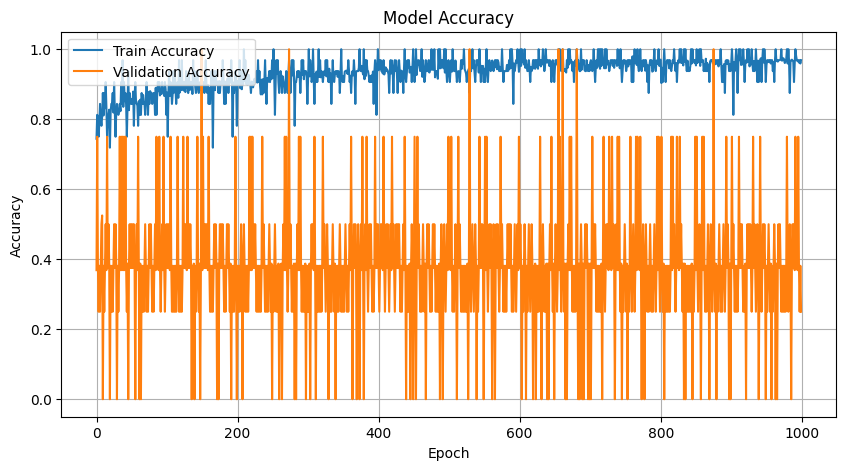

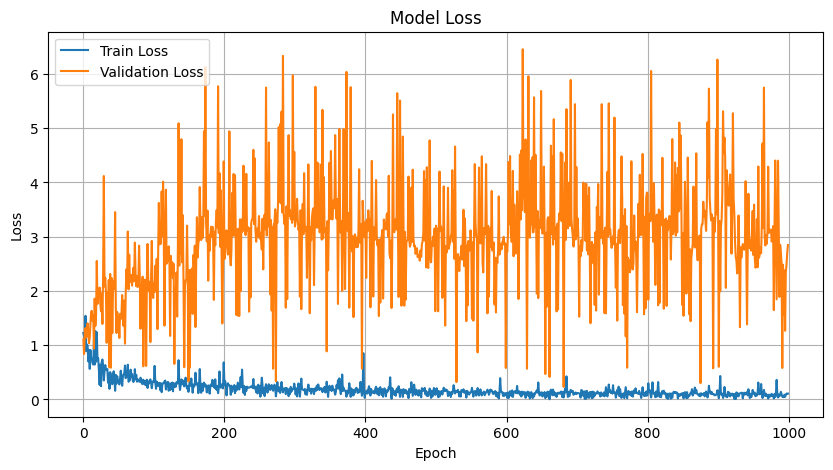

In [8]:
import matplotlib.pyplot as plt

# Plot the accuracy
def plot_accuracy(history):
    plt.figure(figsize=(10, 5))  # Optional: Set figure size for better visualization
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history: # Check if validation accuracy exists
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid()  # Optional: Add grid for better readability
    plt.show()

# Plot the loss
def plot_loss(history):
    plt.figure(figsize=(10, 5))  # Optional: Set figure size for better visualization
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:  # Check if validation loss exists
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid()  # Optional: Add grid for better readability
    plt.show()

# Call the plot functions
plot_accuracy(history)
plot_loss(history)


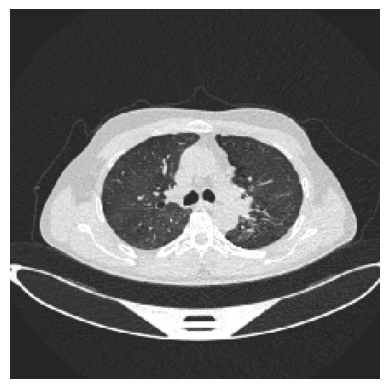

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted class: benign
Prediction confidence: 78.19%


In [13]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt



# Path to the image you want to predict
image_path = r"E:\Conferences\Lung_Cancer\Lung_Cancer_Data\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset\Test\Normal cases\Normal case (23).jpg"

# Step 1: Load the image
img = load_img(image_path, target_size=(224, 224))  # Resize to match input shape
plt.imshow(img)  # Display the image
plt.axis('off')  # Hide axis
plt.show()

# Step 2: Preprocess the image
img_array = img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Rescale pixel values

# Step 3: Make a prediction
predictions = model.predict(img_array)

# Step 4: Interpret the prediction
class_indices = {0: 'normal', 1: 'malignant', 2: 'benign'}  # Update according to your dataset's class indices
predicted_class = np.argmax(predictions, axis=1)  # Get the index of the highest score

# Display the result
print(f"Predicted class: {class_indices[predicted_class[0]]}")
print(f"Prediction confidence: {np.max(predictions) * 100:.2f}%")


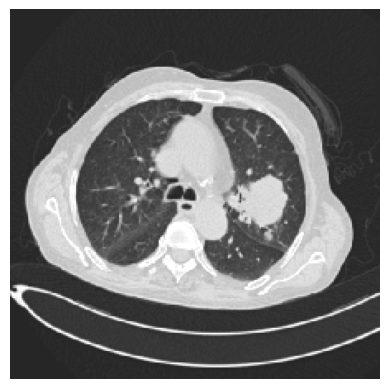

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted class: benign
Prediction confidence: 78.25%


In [14]:
image_path = r"E:\Conferences\Lung_Cancer\Lung_Cancer_Data\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset\Test\Malignant cases\Malignant case (4).jpg"
# Step 1: Load the image
img = load_img(image_path, target_size=(224, 224))  # Resize to match input shape
plt.imshow(img)  # Display the image
plt.axis('off')  # Hide axis
plt.show()

# Step 2: Preprocess the image
img_array = img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Rescale pixel values

# Step 3: Make a prediction
predictions = model.predict(img_array)

# Step 4: Interpret the prediction
class_indices = {0: 'normal', 1: 'malignant', 2: 'benign'}  # Update according to your dataset's class indices
predicted_class = np.argmax(predictions, axis=1)  # Get the index of the highest score

# Display the result
print(f"Predicted class: {class_indices[predicted_class[0]]}")
print(f"Prediction confidence: {np.max(predictions) * 100:.2f}%")


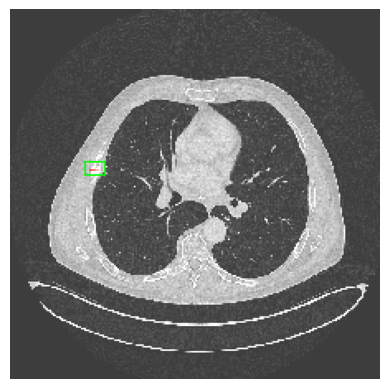

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted class: benign
Prediction confidence: 78.26%


In [15]:
image_path = r"E:\Conferences\Lung_Cancer\Lung_Cancer_Data\Test cases\000328_08_03_167.png"
# Step 1: Load the image
img = load_img(image_path, target_size=(224, 224))  # Resize to match input shape
plt.imshow(img)  # Display the image
plt.axis('off')  # Hide axis
plt.show()

# Step 2: Preprocess the image
img_array = img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Rescale pixel values

# Step 3: Make a prediction
predictions = model.predict(img_array)

# Step 4: Interpret the prediction
class_indices = {0: 'normal', 1: 'malignant', 2: 'benign'}  # Update according to your dataset's class indices
predicted_class = np.argmax(predictions, axis=1)  # Get the index of the highest score

# Display the result
print(f"Predicted class: {class_indices[predicted_class[0]]}")
print(f"Prediction confidence: {np.max(predictions) * 100:.2f}%")


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 291ms/step
True labels: 166, Predictions: 166


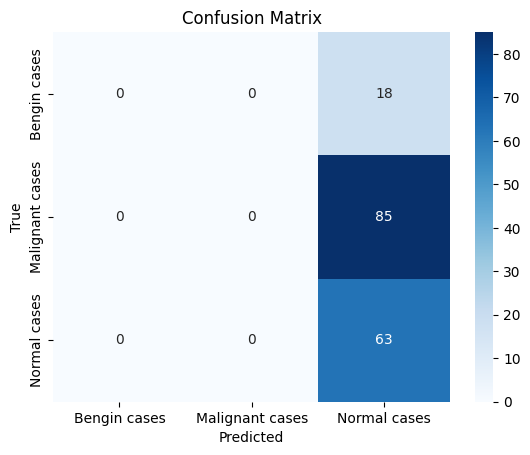

                 precision    recall  f1-score   support

   Bengin cases       0.00      0.00      0.00        18
Malignant cases       0.00      0.00      0.00        85
   Normal cases       0.38      1.00      0.55        63

       accuracy                           0.38       166
      macro avg       0.13      0.33      0.18       166
   weighted avg       0.14      0.38      0.21       166



c:\Users\Al forsan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Al forsan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Al forsan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on the test set
test_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
test_pred_classes = np.argmax(test_pred, axis=1)

# Get true labels
true_classes = test_generator.classes

# Ensure sizes match
print(f"True labels: {len(true_classes)}, Predictions: {len(test_pred_classes)}")

# Confusion Matrix
cm = confusion_matrix(true_classes, test_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(true_classes, test_pred_classes, target_names=list(test_generator.class_indices.keys())))

